In [107]:
from binarytoydata import *
from dummymodels import *
%load_ext autoreload
import pandas as pd
import torch.distributions as dist
import torch
import pandas as pd
import numpy as np
import sklearn
import itertools
from binary_data_tools import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
- z, x0, x1, t and y all binary
- two x so that the data is identifiable by Pearl's method
- Expectation value in ELBO calculated exactly since z has just one of two values
- VAE prior on z is P(z) = 0.5
- z->x0, z->x1, z->t, z->y|t=0 and z->y|t=1 networks are just logistic regression since it should be enough
- (x0,x1,t,y)->z is 8 different logistic regressions where the regression is is done on y for all different (x0,x1,t) combinations
    - So the actual expression is something like $q_{000}(z|y) (1-x_0)(1-x_1)(1-t) + q_{001}(z|y) (1-x_0)(1-x_1)t ...$ 
    - Should be enough in principle to represent p(z|x0,x1,t,y)
- Questions:
    - Do we get the right ATE?
    - Do we get the right P(z,x,t,y)?
    - Does the entire method break if the data generating process doesn't match with prior P(z)?

# Experiment 1, P_z = 0.5

In [363]:
num_samples = 10000
z_expectation = torch.Tensor([0.5])
x_expectations = torch.Tensor([[0.1,0.9],
                              [0.9,0.1]])
x_dim = len(x_expectations)
t_expectations = torch.Tensor([[0.9,0.1]])
y_expectations = torch.Tensor([[0.1,0.8,0.2,0.95]])
df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)

In [364]:
"""Get the convenience function and define the corresponding dataframe"""
calculate_prob = generate_calculate_prob(z_expectation, x_expectations, t_expectations, y_expectations)
prob_df = pd.DataFrame([c + (calculate_prob(c[0], c[1:3], c[3], c[4]),) for c in itertools.product([0,1],repeat=5)], 
                       columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t', 'yf', 'P'])

In [365]:
"""Calculating the true ATE and the ATE we get by adjusting just for the proxies"""
print("True and proxy based ATEs: {:.3f}, {:.3f}".format(calculate_true_ate(prob_df), 
    calculate_proxy_ate(prob_df)))

True and proxy based ATEs: 0.725, 0.697


In [366]:
"""Functions that do P(y=1|X,t) and P(y=1|t) predictions perfectly"""
%autoreload 2
p_y_xt_f = generate_p_y_xt(prob_df)
p_t_x_f = generate_p_t_x(prob_df)
q_y_xt_f = generate_q_y_xt(df)
q_t_x_f = generate_q_t_x(df)

In [126]:
"""Run this before the first time running the next cell"""
i = 0
j = 0
dfs = [[0 for j in range(10)] for i in range(len(datasizes))]
models = [[0 for j in range(10)] for i in range(len(datasizes))]

In [127]:
"""Runs the model for different datasets multiple times"""
BATCH_SIZE = 1000
datasize_times = 10
device = 'cpu'
datasizes = [1000,2000,6000,10000,15000]
#what results are we gathering?

#Simulating datasets and training models
while i < len(datasizes):
    #dfs.append([])
    #models.append([])
    while j < datasize_times:
        num_samples = datasizes[i]
        print("Training data size {}, run {}".format(num_samples, j+1))
        df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)
        dataset = BinaryDataset(df)
        dataloader = BinaryDataLoader(dataset, validation_split=0.0)
        train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
        #dummy test loader
        test_loader, _ = BinaryDataLoader(BinaryDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)
        #Running the model
        model = run_cevae(num_epochs=200, lr_start=0.3, lr_end=0.01,
                train_loader=train_loader, test_loader=test_loader, input_dim=2,
                plot_curves=False, print_logs=False)
    
        dfs[i][j] = df
        models[i][j] = model
        
        torch.save(model.state_dict(), "./dummy_data/model{}_{}".format(num_samples,j))
        df.to_pickle("./dummy_data/data{}_{}".format(num_samples,j))
        
        x = torch.Tensor(df[['x0','x1']].values)
        print("Estimated ATE: {}".format(modelITE(model, x, p_y_xt_f, p_t_x_f).mean()))
        
        j += 1
    j = 0
    i += 1

Training data size 1000, run 1
Estimated ATE: 0.6306077241897583
Training data size 1000, run 2
Estimated ATE: 0.717467725276947
Training data size 1000, run 3
Estimated ATE: 0.6892865896224976
Training data size 1000, run 4
Estimated ATE: 0.7410643100738525
Training data size 1000, run 5
Estimated ATE: 0.6351633071899414
Training data size 1000, run 6
Estimated ATE: 0.6556169986724854
Training data size 1000, run 7
Estimated ATE: 0.5494042634963989
Training data size 1000, run 8
Estimated ATE: 0.7219117283821106
Training data size 1000, run 9
Estimated ATE: 0.6021299362182617
Training data size 1000, run 10
Estimated ATE: 0.6953056454658508
Training data size 2000, run 1
Estimated ATE: 0.7228432893753052
Training data size 2000, run 2
Estimated ATE: 0.6149059534072876
Training data size 2000, run 3
Estimated ATE: 0.7589566111564636
Training data size 2000, run 4
Estimated ATE: 0.7302019000053406
Training data size 2000, run 5
Estimated ATE: 0.7089755535125732
Training data size 2000, 

In [368]:
#Calculating results from the models
model_ITEs_1 = [[] for n in range(len(datasizes))]
model_ITEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_1 = [[] for n in range(len(datasizes))]
model_ATEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_3 = [[] for n in range(len(datasizes))]
proxy_ITEs = [[] for n in range(len(datasizes))]
proxy_ATEs = [[] for n in range(len(datasizes))]
dists_VAE = [[] for n in range(len(datasizes))]
dists_data = [[] for n in range(len(datasizes))]
dists_true = [[] for n in range(len(datasizes))]

for n in range(len(datasizes)):
    for i in range(datasize_times):
        #P(y=1|X,t) and P(t=1|X) estimates directly from the data
        df = dfs[n][i]
        model = models[n][i]
        q_y_xt_f = generate_q_y_xt(df)
        q_t_x_f = generate_q_t_x(df)

        #Getting the ITE and ATE estimates
        x = torch.Tensor(df[['x0','x1']].values)
        p_y_xt_f(x[0][0].item(),x[0][1].item(),1)
        model_ITEs_1[n].append(modelITE(model, x, p_y_xt_f, p_t_x_f))
        model_ITEs_2[n].append(modelITE(model, x, q_y_xt_f, q_t_x_f))
        proxy_ITEs[n].append(proxyITE(x, q_y_xt_f))
        model_ATEs_1[n].append(model_ITEs_1[n][i].mean())
        model_ATEs_2[n].append(model_ITEs_2[n][i].mean())
        proxy_ATEs[n].append(proxy_ITEs[n][i].mean())
        z_sample = dist.Bernoulli(torch.Tensor([0.5])).sample((50000,))
        p_y_do1_model = torch.sigmoid(model.decoder.y1_nn(z_sample)).mean()
        p_y_do0_model =torch.sigmoid(model.decoder.y0_nn(z_sample)).mean()
        model_ATEs_3[n].append(p_y_do1_model - p_y_do0_model)

        #Getting probability distribution estimates
        zs, xs, ts, ys = model.decoder.sample(1000000)
        sample_data = torch.cat([zs, xs,ts,ys],axis=1)
        dist_VAE, dist_data, dist_true = getJointDistributions(sample_data, df[['z','x0','x1','t','yf']],prob_df)
        #Choosing the assignment for z
        dist_VAE_1 = dist_VAE
        dist_VAE_2 = dist_VAE.copy()
        dist_VAE_2.z = 1-dist_VAE_2.z
        dist_VAE_2.sort_values(by=['z','x0','x1','t','yf'], inplace=True, ignore_index=True)
        err_1 = (dist_VAE_1.P - dist_true.P).abs().sum()
        err_2 = (dist_VAE_2.P - dist_true.P).abs().sum()
        if err_1 < err_2:
            dists_VAE[n].append(dist_VAE_1)
        else:
            dists_VAE[n].append(dist_VAE_2)
        dists_data[n].append(dist_data)
        dists_true[n].append(dist_true)

Text(0.5, 1.0, 'sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)')

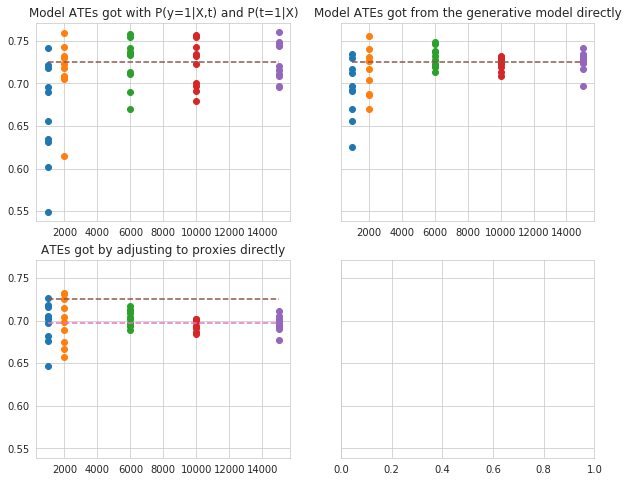

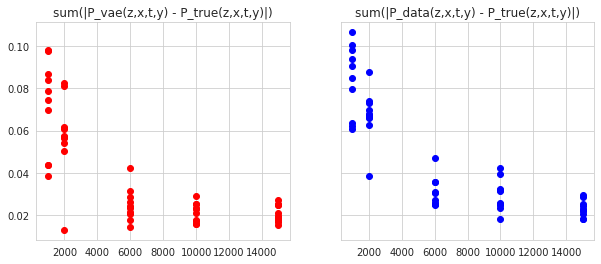

In [369]:
"""Plot results"""
fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=True)
for n in range(len(datasizes)):
    ax[0,0].plot(10*[datasizes[n]], model_ATEs_1[n], 'o')
ax[0,0].plot([1000, 15000], 2*[calculate_true_ate(prob_df)], '--')
ax[0,0].set_title("Model ATEs got with P(y=1|X,t) and P(t=1|X)")

for n in range(len(datasizes)):
    ax[0,1].plot(10*[datasizes[n]], model_ATEs_3[n], 'o')
ax[0,1].plot([1000, 15000], 2*[calculate_true_ate(prob_df)], '--')
ax[0,1].set_title("Model ATEs got from the generative model directly")

for n in range(len(datasizes)):
    ax[1,0].plot(10*[datasizes[n]], proxy_ATEs[n], 'o')
ax[1,0].plot([1000, 15000], 2*[calculate_true_ate(prob_df)], '--')
ax[1,0].plot([1000, 15000], 2*[calculate_proxy_ate(prob_df)], '--')
ax[1,0].set_title("ATEs got by adjusting to proxies directly")

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
for n in range(len(datasizes)):
    for i in range(len(dists_VAE[n])):
        ax[0].plot(datasizes[n], (dists_VAE[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='r')
        ax[1].plot(datasizes[n], (dists_data[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='b')
ax[0].set_title("sum(|P_vae(z,x,t,y) - P_true(z,x,t,y)|)")
ax[1].set_title("sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)")

## Problems
- Optimization not tuned for every sample size, doesn't seem to be completely reliable
- Estimation of the prob dist created by the VAE isn't done optimally here (also the generative ATE)

# Version with P_z != 0.5

In [370]:
num_samples = 10000
z_expectation = torch.Tensor([0.75])
x_expectations = torch.Tensor([[0.1,0.9],
                              [0.9,0.1]])
x_dim = len(x_expectations)
t_expectations = torch.Tensor([[0.9,0.1]])
y_expectations = torch.Tensor([[0.1,0.8,0.2,0.95]])
df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)

In [371]:
"""Get the convenience function and define the corresponding dataframe"""
calculate_prob = generate_calculate_prob(z_expectation, x_expectations, t_expectations, y_expectations)
prob_df = pd.DataFrame([c + (calculate_prob(c[0], c[1:3], c[3], c[4]),) for c in itertools.product([0,1],repeat=5)], 
                       columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t', 'yf', 'P'])

In [372]:
"""Calculating the true ATE and the ATE we get by adjusting just for the proxies"""
print("True and proxy based ATEs: {:.3f}, {:.3f}".format(calculate_true_ate(prob_df), 
    calculate_proxy_ate(prob_df)))

True and proxy based ATEs: 0.737, 0.712


In [373]:
"""Functions that do P(y=1|X,t) and P(y=1|t) predictions perfectly"""
%autoreload 2
p_y_xt_f = generate_p_y_xt(prob_df)
p_t_x_f = generate_p_t_x(prob_df)
q_y_xt_f = generate_q_y_xt(df)
q_t_x_f = generate_q_t_x(df)

In [266]:
"""Run this before the first time running the next cell"""
i = 0
j = 0
dfs2 = [[0 for j in range(10)] for i in range(len(datasizes))]
models2 = [[0 for j in range(10)] for i in range(len(datasizes))]

In [268]:
"""Runs the model for different datasets multiple times"""
BATCH_SIZE = 1000
datasize_times = 10
device = 'cpu'
datasizes = [1000,2000,6000,10000,15000]
#what results are we gathering?

#Simulating datasets and training models
while i < len(datasizes):
    #dfs.append([])
    #models.append([])
    while j < datasize_times:
        num_samples = datasizes[i]
        print("Training data size {}, run {}".format(num_samples, j+1))
        df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)
        dataset = BinaryDataset(df)
        dataloader = BinaryDataLoader(dataset, validation_split=0.0)
        train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
        #dummy test loader
        test_loader, _ = BinaryDataLoader(BinaryDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)
        #Running the model
        model = run_cevae(num_epochs=200, lr_start=0.3, lr_end=0.01,
                train_loader=train_loader, test_loader=test_loader, input_dim=2,
                plot_curves=False, print_logs=False)
    
        dfs2[i][j] = df
        models2[i][j] = model
        
        torch.save(model.state_dict(), "./dummy_data/model2{}_{}".format(num_samples,j))
        df.to_pickle("./dummy_data/data2{}_{}".format(num_samples,j))
        
        x = torch.Tensor(df[['x0','x1']].values)
        print("Estimated ATE: {}".format(modelITE(model, x, p_y_xt_f, p_t_x_f).mean()))
        
        j += 1
    j = 0
    i += 1

Training data size 10000, run 5
Estimated ATE: 0.6554248929023743
Training data size 10000, run 6
Estimated ATE: 0.6482690572738647
Training data size 10000, run 7
Estimated ATE: 0.6363511085510254
Training data size 10000, run 8
Estimated ATE: 0.6688422560691833
Training data size 10000, run 9
Estimated ATE: 0.6483574509620667
Training data size 10000, run 10
Estimated ATE: 0.6680180430412292
Training data size 15000, run 1
Estimated ATE: 0.6537138819694519
Training data size 15000, run 2
Estimated ATE: 0.7803032398223877
Training data size 15000, run 3
Estimated ATE: 0.6661369204521179
Training data size 15000, run 4
Estimated ATE: 0.6669609546661377
Training data size 15000, run 5
Estimated ATE: 0.6401401162147522
Training data size 15000, run 6
Estimated ATE: 0.6637275218963623
Training data size 15000, run 7
Estimated ATE: 0.6604102253913879
Training data size 15000, run 8
Estimated ATE: 0.6217547655105591
Training data size 15000, run 9
Estimated ATE: 0.6390078663825989
Training 

In [374]:
#Calculating results from the models
model_ITEs_1 = [[] for n in range(len(datasizes))]
model_ITEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_1 = [[] for n in range(len(datasizes))]
model_ATEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_3 = [[] for n in range(len(datasizes))]
proxy_ITEs = [[] for n in range(len(datasizes))]
proxy_ATEs = [[] for n in range(len(datasizes))]
dists_VAE = [[] for n in range(len(datasizes))]
dists_data = [[] for n in range(len(datasizes))]
dists_true = [[] for n in range(len(datasizes))]

for n in range(len(datasizes)):
    for i in range(datasize_times):
        #P(y=1|X,t) and P(t=1|X) estimates directly from the data
        df = dfs2[n][i]
        model = models2[n][i]
        q_y_xt_f = generate_q_y_xt(df)
        q_t_x_f = generate_q_t_x(df)

        #Getting the ITE and ATE estimates
        x = torch.Tensor(df[['x0','x1']].values)
        p_y_xt_f(x[0][0].item(),x[0][1].item(),1)
        model_ITEs_1[n].append(modelITE(model, x, p_y_xt_f, p_t_x_f))
        model_ITEs_2[n].append(modelITE(model, x, q_y_xt_f, q_t_x_f))
        proxy_ITEs[n].append(proxyITE(x, q_y_xt_f))
        model_ATEs_1[n].append(model_ITEs_1[n][i].mean())
        model_ATEs_2[n].append(model_ITEs_2[n][i].mean())
        proxy_ATEs[n].append(proxy_ITEs[n][i].mean())
        z_sample = dist.Bernoulli(torch.Tensor([0.5])).sample((50000,))
        p_y_do1_model = torch.sigmoid(model.decoder.y1_nn(z_sample)).mean()
        p_y_do0_model =torch.sigmoid(model.decoder.y0_nn(z_sample)).mean()
        model_ATEs_3[n].append(p_y_do1_model - p_y_do0_model)

        #Getting probability distribution estimates
        zs, xs, ts, ys = model.decoder.sample(1000000)
        sample_data = torch.cat([zs, xs,ts,ys],axis=1)
        dist_VAE, dist_data, dist_true = getJointDistributions(sample_data, df[['z','x0','x1','t','yf']],prob_df)
        #Choosing the assignment for z
        dist_VAE_1 = dist_VAE
        dist_VAE_2 = dist_VAE.copy()
        dist_VAE_2.z = 1-dist_VAE_2.z
        dist_VAE_2.sort_values(by=['z','x0','x1','t','yf'], inplace=True, ignore_index=True)
        err_1 = (dist_VAE_1.P - dist_true.P).abs().sum()
        err_2 = (dist_VAE_2.P - dist_true.P).abs().sum()
        if err_1 < err_2:
            dists_VAE[n].append(dist_VAE_1)
        else:
            dists_VAE[n].append(dist_VAE_2)
        dists_data[n].append(dist_data)
        dists_true[n].append(dist_true)

Text(0.5, 1.0, 'sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)')

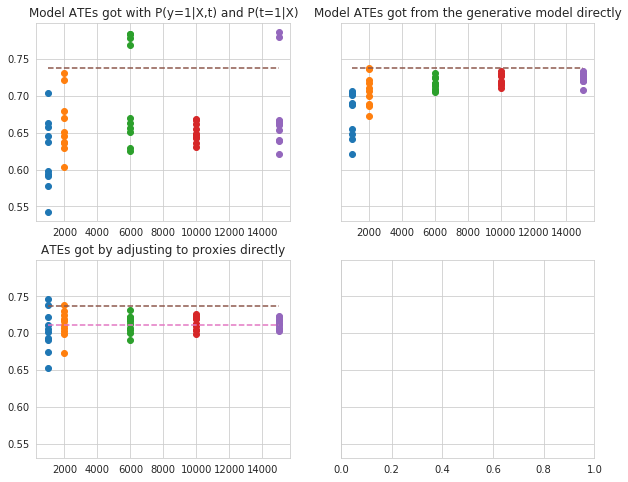

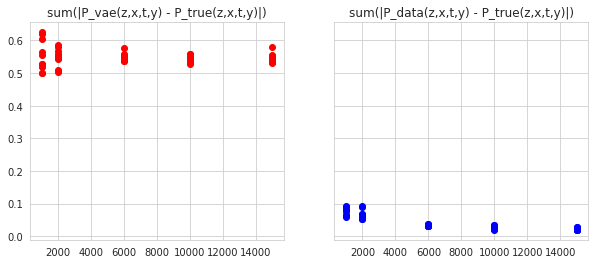

In [375]:
"""Plot results"""
fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=True)
for n in range(len(datasizes)):
    ax[0,0].plot(10*[datasizes[n]], model_ATEs_1[n], 'o')
ax[0,0].plot([1000, 15000], 2*[calculate_true_ate(prob_df)], '--')
ax[0,0].set_title("Model ATEs got with P(y=1|X,t) and P(t=1|X)")

for n in range(len(datasizes)):
    ax[0,1].plot(10*[datasizes[n]], model_ATEs_3[n], 'o')
ax[0,1].plot([1000, 15000], 2*[calculate_true_ate(prob_df)], '--')
ax[0,1].set_title("Model ATEs got from the generative model directly")

for n in range(len(datasizes)):
    ax[1,0].plot(10*[datasizes[n]], proxy_ATEs[n], 'o')
ax[1,0].plot([1000, 15000], 2*[calculate_true_ate(prob_df)], '--')
ax[1,0].plot([1000, 15000], 2*[calculate_proxy_ate(prob_df)], '--')
ax[1,0].set_title("ATEs got by adjusting to proxies directly")

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
for n in range(len(datasizes)):
    for i in range(len(dists_VAE[n])):
        ax[0].plot(datasizes[n], (dists_VAE[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='r')
        ax[1].plot(datasizes[n], (dists_data[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='b')
ax[0].set_title("sum(|P_vae(z,x,t,y) - P_true(z,x,t,y)|)")
ax[1].set_title("sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)")

## Thoughts
- Treat P(z) as a parameter also?
- What happens when P(z) is Gaussian again?

# Free-form testing

In [ ]:
num_samples = 10000
z_expectation = torch.Tensor([0.5])
x_expectations = torch.Tensor([[0.1,0.9],
                              [0.9,0.1]])
x_dim = len(x_expectations)
t_expectations = torch.Tensor([[0.9,0.1]])
y_expectations = torch.Tensor([[0.1,0.8,0.2,0.95]])
df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)

In [10]:
%autoreload 2
BATCH_SIZE = 10000
device = 'cpu'
dataset = BinaryDataset(df)
dataloader = BinaryDataLoader(dataset, validation_split=0.0)
train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
#dummy test loader
test_loader, _ = BinaryDataLoader(BinaryDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)

In [98]:
model = run_cevae(num_epochs=200, lr_start=0.3, lr_end=0.01,
                  train_loader=train_loader, test_loader=test_loader, input_dim=2,
                 plot_curves=True, print_logs=True)

In [101]:
%autoreload 2
zs, xs, ts, ys = model.decoder.sample(20000)

In [104]:
print("Marginal probs according to VAE and according to the data")

sample_data = torch.cat([xs,ts,ys],axis=1)
printCombinations(sample_data, df[['x0','x1','t','yf']],prob_df)

sample_data = torch.cat([ts,ys],axis=1)
printCombinations(sample_data, df[['t','yf']],prob_df)

sample_data = torch.cat([ts,ys,zs],axis=1)
printCombinations(sample_data, df[['t','yf','z']],prob_df)

Marginal probs according to VAE and according to the data
P(x0=0,x1=0,t=0,yf=0)	0.0375(VAE)	=0.0389(data)	0.0365(true)
P(x0=0,x1=0,t=0,yf=1)	0.00935(VAE)	=0.0067(data)	0.0086(true)
P(x0=0,x1=0,t=1,yf=0)	0.00905(VAE)	=0.0085(data)	0.0083(true)
P(x0=0,x1=0,t=1,yf=1)	0.03555(VAE)	=0.0355(data)	0.0367(true)
P(x0=0,x1=1,t=0,yf=0)	0.03695(VAE)	=0.0402(data)	0.0401(true)
P(x0=0,x1=1,t=0,yf=1)	0.0067(VAE)	=0.0052(data)	0.0050(true)
P(x0=0,x1=1,t=1,yf=0)	0.06975(VAE)	=0.0703(data)	0.0729(true)
P(x0=0,x1=1,t=1,yf=1)	0.29225(VAE)	=0.2937(data)	0.2921(true)
P(x0=1,x1=0,t=0,yf=0)	0.29475(VAE)	=0.291(data)	0.2920(true)
P(x0=1,x1=0,t=0,yf=1)	0.0738(VAE)	=0.0733(data)	0.0729(true)
P(x0=1,x1=0,t=1,yf=0)	0.00415(VAE)	=0.0031(data)	0.0029(true)
P(x0=1,x1=0,t=1,yf=1)	0.03415(VAE)	=0.036(data)	0.0421(true)
P(x0=1,x1=1,t=0,yf=0)	0.03745(VAE)	=0.039(data)	0.0364(true)
P(x0=1,x1=1,t=0,yf=1)	0.0099(VAE)	=0.0092(data)	0.0085(true)
P(x0=1,x1=1,t=1,yf=0)	0.00835(VAE)	=0.0087(data)	0.0083(true)
P(x0=1,x1=1,t=1,yf=

In [ ]:
sample_data = torch.cat([xs,ts,ys,zs],axis=1)
printCombinations(sample_data, df[['x0','x1','t','yf','z']])